In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import yfinance as yf

In [2]:
FILE_PATH = '../data/gspc-etf.csv'


if os.path.exists(FILE_PATH):
    data = pd.read_csv(FILE_PATH)
else:
    data = yf.Ticker("^GSPC")
    data = data.history(period="max")
    data.to_csv(FILE_PATH)

In [3]:
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...,...
24104,2023-12-14 00:00:00-05:00,4721.040039,4738.569824,4694.339844,4719.549805,6314040000,0.0,0.0
24105,2023-12-15 00:00:00-05:00,4714.229980,4725.529785,4704.689941,4719.189941,8218980000,0.0,0.0
24106,2023-12-18 00:00:00-05:00,4725.580078,4749.520020,4725.580078,4740.560059,4060340000,0.0,0.0
24107,2023-12-19 00:00:00-05:00,4743.720215,4768.689941,4743.720215,4768.370117,4026970000,0.0,0.0


In [4]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1927-12-30 00:00:00-05:00,17.660000
1,1928-01-03 00:00:00-05:00,17.760000
2,1928-01-04 00:00:00-05:00,17.719999
3,1928-01-05 00:00:00-05:00,17.549999
4,1928-01-06 00:00:00-05:00,17.660000
...,...,...
24104,2023-12-14 00:00:00-05:00,4719.549805
24105,2023-12-15 00:00:00-05:00,4719.189941
24106,2023-12-18 00:00:00-05:00,4740.560059
24107,2023-12-19 00:00:00-05:00,4768.370117


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

/var/folders/5t/1wwb4x_d4hd53smqcd96d_500000gn/T/ipykernel_88606/1819287010.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])
/var/folders/5t/1wwb4x_d4hd53smqcd96d_500000gn/T/ipykernel_88606/1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


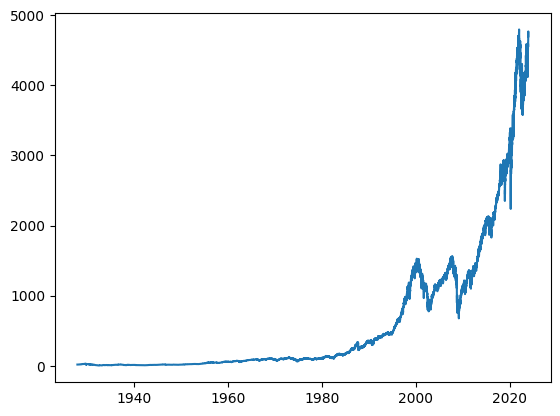

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1928-01-11 00:00:00-05:00,17.350000,17.370001,17.500000,17.660000,17.549999,17.719999,17.760000,17.660000
1928-01-12 00:00:00-05:00,17.469999,17.350000,17.370001,17.500000,17.660000,17.549999,17.719999,17.760000
1928-01-13 00:00:00-05:00,17.580000,17.469999,17.350000,17.370001,17.500000,17.660000,17.549999,17.719999
1928-01-16 00:00:00-05:00,17.290001,17.580000,17.469999,17.350000,17.370001,17.500000,17.660000,17.549999
1928-01-17 00:00:00-05:00,17.299999,17.290001,17.580000,17.469999,17.350000,17.370001,17.500000,17.660000
...,...,...,...,...,...,...,...,...
2023-12-14 00:00:00-05:00,4719.549805,4707.089844,4643.700195,4622.439941,4604.370117,4585.589844,4549.339844,4567.180176
2023-12-15 00:00:00-05:00,4719.189941,4719.549805,4707.089844,4643.700195,4622.439941,4604.370117,4585.589844,4549.339844
2023-12-18 00:00:00-05:00,4740.560059,4719.189941,4719.549805,4707.089844,4643.700195,4622.439941,4604.370117,4585.589844


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  17.35000038,   17.37000084,   17.5       , ...,   17.71999931,
          17.76000023,   17.65999985],
       [  17.46999931,   17.35000038,   17.37000084, ...,   17.54999924,
          17.71999931,   17.76000023],
       [  17.57999992,   17.46999931,   17.35000038, ...,   17.65999985,
          17.54999924,   17.71999931],
       ...,
       [4740.56005859, 4719.18994141, 4719.54980469, ..., 4622.43994141,
        4604.37011719, 4585.58984375],
       [4768.37011719, 4740.56005859, 4719.18994141, ..., 4643.70019531,
        4622.43994141, 4604.37011719],
       [4698.35009766, 4768.37011719, 4740.56005859, ..., 4707.08984375,
        4643.70019531, 4622.43994141]])

In [9]:
shifted_df_as_np.shape

(24102, 8)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99459534, -0.99458699, -0.99453274, ..., -0.99444092,
        -0.99442423, -0.99446596],
       [-0.99454526, -0.99459534, -0.99458699, ..., -0.99451187,
        -0.99444092, -0.99442423],
       [-0.99449935, -0.99454526, -0.99459534, ..., -0.99446596,
        -0.99451187, -0.99444092],
       ...,
       [ 0.97662849,  0.96770971,  0.9678599 , ...,  0.92733126,
         0.91978985,  0.91195193],
       [ 0.98823498,  0.97662849,  0.96770971, ...,  0.93620419,
         0.92733126,  0.91978985],
       [ 0.95901224,  0.98823498,  0.97662849, ...,  0.96265976,
         0.93620419,  0.92733126]])

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((24102, 7), (24102,))

flip the Axes of X so the RNN can see the previous days prices in the correct sequence.

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99446596, -0.99442423, -0.99444092, ..., -0.99446596,
        -0.99453274, -0.99458699],
       [-0.99442423, -0.99444092, -0.99451187, ..., -0.99453274,
        -0.99458699, -0.99459534],
       [-0.99444092, -0.99451187, -0.99446596, ..., -0.99458699,
        -0.99459534, -0.99454526],
       ...,
       [ 0.91195193,  0.91978985,  0.92733126, ...,  0.96265976,
         0.9678599 ,  0.96770971],
       [ 0.91978985,  0.92733126,  0.93620419, ...,  0.9678599 ,
         0.96770971,  0.97662849],
       [ 0.92733126,  0.93620419,  0.96265976, ...,  0.96770971,
         0.97662849,  0.98823498]])

Split training and dataset into 95:5 split. Adding an extra dimension to satisfy pytorch LSTM shape requirement. Wrapped the numpy arrays into tensors.

In [13]:
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([22896, 7, 1]),
 torch.Size([1206, 7, 1]),
 torch.Size([22896, 1]),
 torch.Size([1206, 1]))

Create a dataset custom class

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Splitting the data into batches

In [16]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 7, 1]) torch.Size([32, 1])


Build the LSTM model

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        
        # Add an extra fully connected layer
        self.fc1 = nn.Linear(hidden_size, 50)  # Adjust the output size as needed
        self.fc2 = nn.Linear(50, 1)  # Adjust the input size to match the output size of fc1

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply the extra fully connected layers
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)

        return out

model = LSTM(1, 32, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [18]:
# learning_rate = 0.001
num_epochs = 25
loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters())

In [19]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [20]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [21]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.114
Batch 200, Loss: 0.002
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000

Val Loss: 0.044
***************************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000

Val Loss: 0.026
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000

Val Loss: 0.013
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000

Val Loss: 0.009
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 20

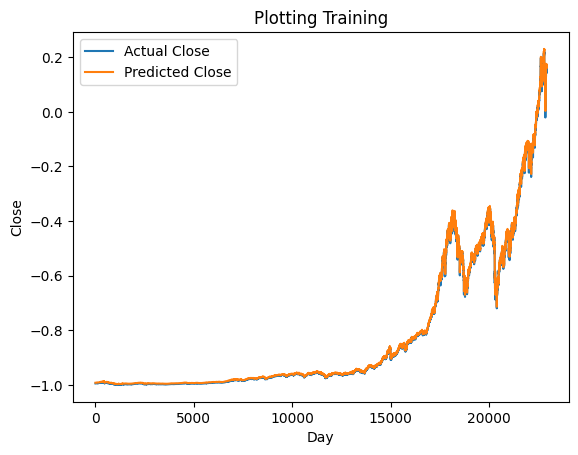

In [22]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.title('Plotting Training')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [23]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  23.50583948,   23.44842684,   23.4872732 , ..., 2816.27325463,
       2804.16325903, 2785.40478751])

In [24]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  17.34997682,   17.46994352,   17.58005581, ..., 2771.44994687,
       2748.92994806, 2743.07007467])

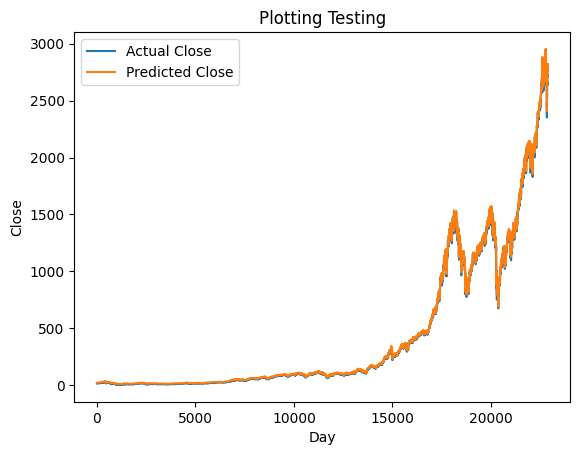

In [25]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.title('Plotting Testing')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [26]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([2773.71778164, 2792.70979547, 2807.01975183, ..., 4773.27937808,
       4789.1372619 , 4811.32081839])

In [27]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([2783.30005033, 2791.52001859, 2810.9199192 , ..., 4740.56003188,
       4768.37016937, 4698.35003442])

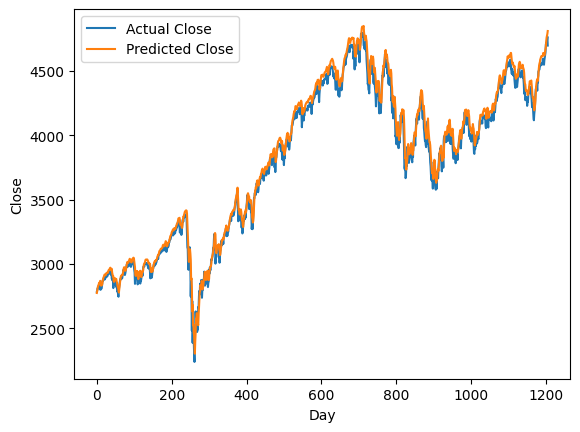

In [28]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [29]:
from sklearn.metrics import mean_absolute_percentage_error

class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

baseline_evals = Evaluate(new_y_test, test_predictions)
baseline_evals.mape, baseline_evals.var_ratio

(0.013697569479769188, 0.042971812495566475)